# ML Pipeline

This notebook contain all the steps we performed during the ML exploration phase. Before running this notebook, make sure you read the [README.md](../README.md) file.

In [1]:
%load_ext autoreload
%autoreload 2

from assaiku.data import DataConfig

from assaiku.model.configs import EvaluationConfig
from assaiku.model.evaluation import evaluate_model
from assaiku.model.processors import (
    fit_processor,
    initialize_feat_processor,
    split_transform,
)
from assaiku.model.train import initialize_model, train_model
from assaiku.model.configs import LogisticRegressionConfig, EvaluationConfig, LinearSVMConfig, XGBConfig
from assaiku.model import MLPipe
from assaiku.data import DataPipe

import pandas as pd

pd.set_option('display.max_columns', 50)

## Generating clean data

Let's generate clean data using the data pipeline

Removing duplicates train set
Number of duplicates including instances_weights: 3229
Number of duplicates excluding instances_weights: 46627
Dropping duplicates including the instances_weight (systematic error)
Gropuping same instances and their weight instances
Number of samples after cleaning: 152896
Removing duplicates test set
Number of duplicates including instances_weights: 883
Number of duplicates excluding instances_weights: 20898
Dropping duplicates including the instances_weight (systematic error)
Gropuping same instances and their weight instances
Number of samples after cleaning: 78864
Found 31 outlier in train set


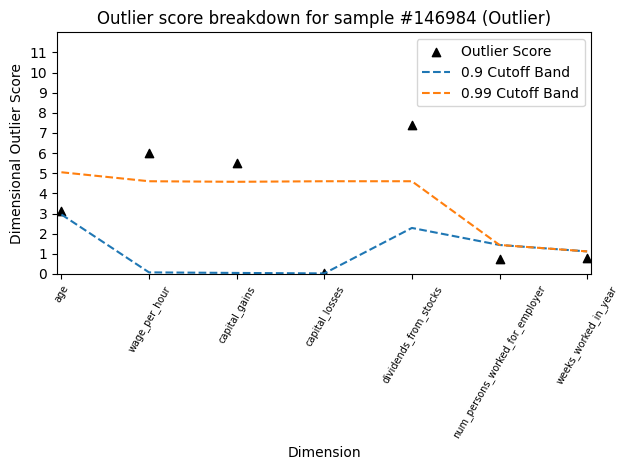

Found 12 outlier in test set
Filtering out outliers from train and test data


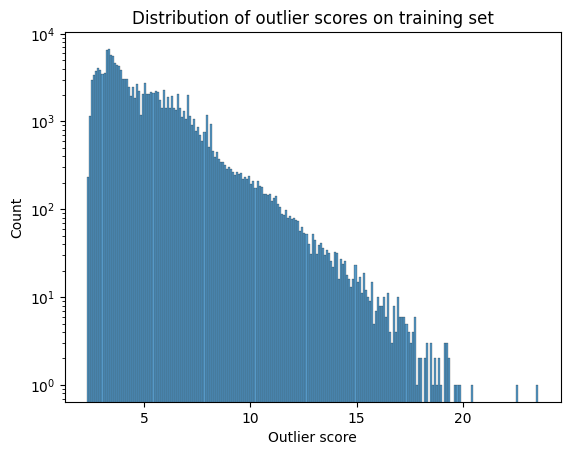

In [2]:
data_config = DataConfig(perform_exploration=False)
data_pipeline = DataPipe(data_config=data_config)
data_pipeline.run()

## Loading data generated by Data Pipeline

In [3]:
train_data = pd.read_parquet(path=data_config.train_data_out)
test_data = pd.read_parquet(path=data_config.test_data_out)

## Configure the model

We created pydantic basemodel, to configure the model and the preprocessing steps.

In [4]:
model_config = XGBConfig(n_estimators=100,
        max_depth=7,
        learning_rate=1e-1,
        dimension_red=None)

## Initiliaze the data processor and fit it

First we will initialize our preprocessor, that will perform the following steps:
- Standardize continuous features
- One hot encode cetagorical features
- `Optional` Perform feature augmentation with `RBF kernel`
- `Optional` Perform dimensionality reduction with `PCA`


In [5]:
feat_processor, label_binarizer = initialize_feat_processor(
                data_config=data_config, model_config=model_config
            )
fit_processor(
    train_data=train_data,
    feature_cols=data_config.features,
    pipeline=feat_processor,
)

## Split and transform data for each data set

Let's transform the data for the training set and testing set. 

In [6]:
x_train, y_train, w_train = split_transform(
                train_data,
                feat_processor,
                label_binarizer,
                data_config=data_config,
            )
x_test, y_test, w_test = split_transform(
    test_data,
    feat_processor,
    label_binarizer,
    data_config=data_config,
)

## Train model

Let's initiliaze the model and train it accordingly to what is specified in the configuration. In the training part, we put an option to rebalance the weights based on the label frequency.

In [7]:
model = initialize_model(model_config=model_config)

train_model(
    model_config=model_config,
    x_train=x_train,
    y_train=y_train,
    weights=w_train,
    model=model,
)

Training model XGB(dimred=False)
Positive weights set to 3.925207024475412
Negative weights set to 1.0341225738753932


## Evaluate model

Let's evaluate the performances of the model we trained on both train and test set. To evaluate the performances of the model we use the following metrics:
- Recall
- Precision
- F1

The choice of such metrics was justified by the unbalanced aspect of the labels

In [8]:
train_perf_0, train_perf_1 = evaluate_model(
    model=model,
    x=x_train,
    y=y_train,
    weights=w_train,
    data_set="train",
    model_name=model_config.name,
)

test_perf_0, test_perf_1 = evaluate_model(
    model=model,
    x=x_test,
    y=y_test,
    weights=w_test,
    data_set="test",
    model_name=model_config.name,
)

data = pd.DataFrame.from_records([train_perf_0, test_perf_0, test_perf_1, train_perf_1])
print(data.to_markdown(index=False))

Evaluating on train set
Model = XGB(dimred=False) - Precision [0.98273045 0.57370812] - Recall [0.96097349 0.7567017 ] - F1 [0.9717302  0.65261983]
Evaluating on test set
Model = XGB(dimred=False) - Precision [0.98037057 0.54034127] - Recall [0.95833419 0.71851377] - F1 [0.96922714 0.61681866]
|   precision |   recall |       f1 |   class | model             | set   |
|------------:|---------:|---------:|--------:|:------------------|:------|
|    0.98273  | 0.960973 | 0.97173  |       0 | XGB(dimred=False) | train |
|    0.980371 | 0.958334 | 0.969227 |       0 | XGB(dimred=False) | test  |
|    0.540341 | 0.718514 | 0.616819 |       1 | XGB(dimred=False) | test  |
|    0.573708 | 0.756702 | 0.65262  |       1 | XGB(dimred=False) | train |


## Compare different models in one line

All the steps presented above are wrapped into the ML pipeline. In addition it does the following:
- Retrain several times the model with same configuration but different initialization to get meaningful metrics about performances
- Train several different models based on the configurations given as input.
- Visualize the results

Fitting processor for model XGB(dimred=False)
Model XGB(dimred=False) | Repet [1/2]
Training model XGB(dimred=False)
Positive weights set to 3.925207024475412
Negative weights set to 1.0341225738753932
Evaluating on train set
Model = XGB(dimred=False) - Precision [0.98273045 0.57370812] - Recall [0.96097349 0.7567017 ] - F1 [0.9717302  0.65261983]
Evaluating on test set
Model = XGB(dimred=False) - Precision [0.98037057 0.54034127] - Recall [0.95833419 0.71851377] - F1 [0.96922714 0.61681866]
Model XGB(dimred=False) | Repet [2/2]
Training model XGB(dimred=False)
Positive weights set to 3.925207024475412
Negative weights set to 1.0341225738753932
Evaluating on train set
Model = XGB(dimred=False) - Precision [0.98273045 0.57370812] - Recall [0.96097349 0.7567017 ] - F1 [0.9717302  0.65261983]
Evaluating on test set
Model = XGB(dimred=False) - Precision [0.98037057 0.54034127] - Recall [0.95833419 0.71851377] - F1 [0.96922714 0.61681866]
Fitting processor for model XGB(dimred=True)
Model X

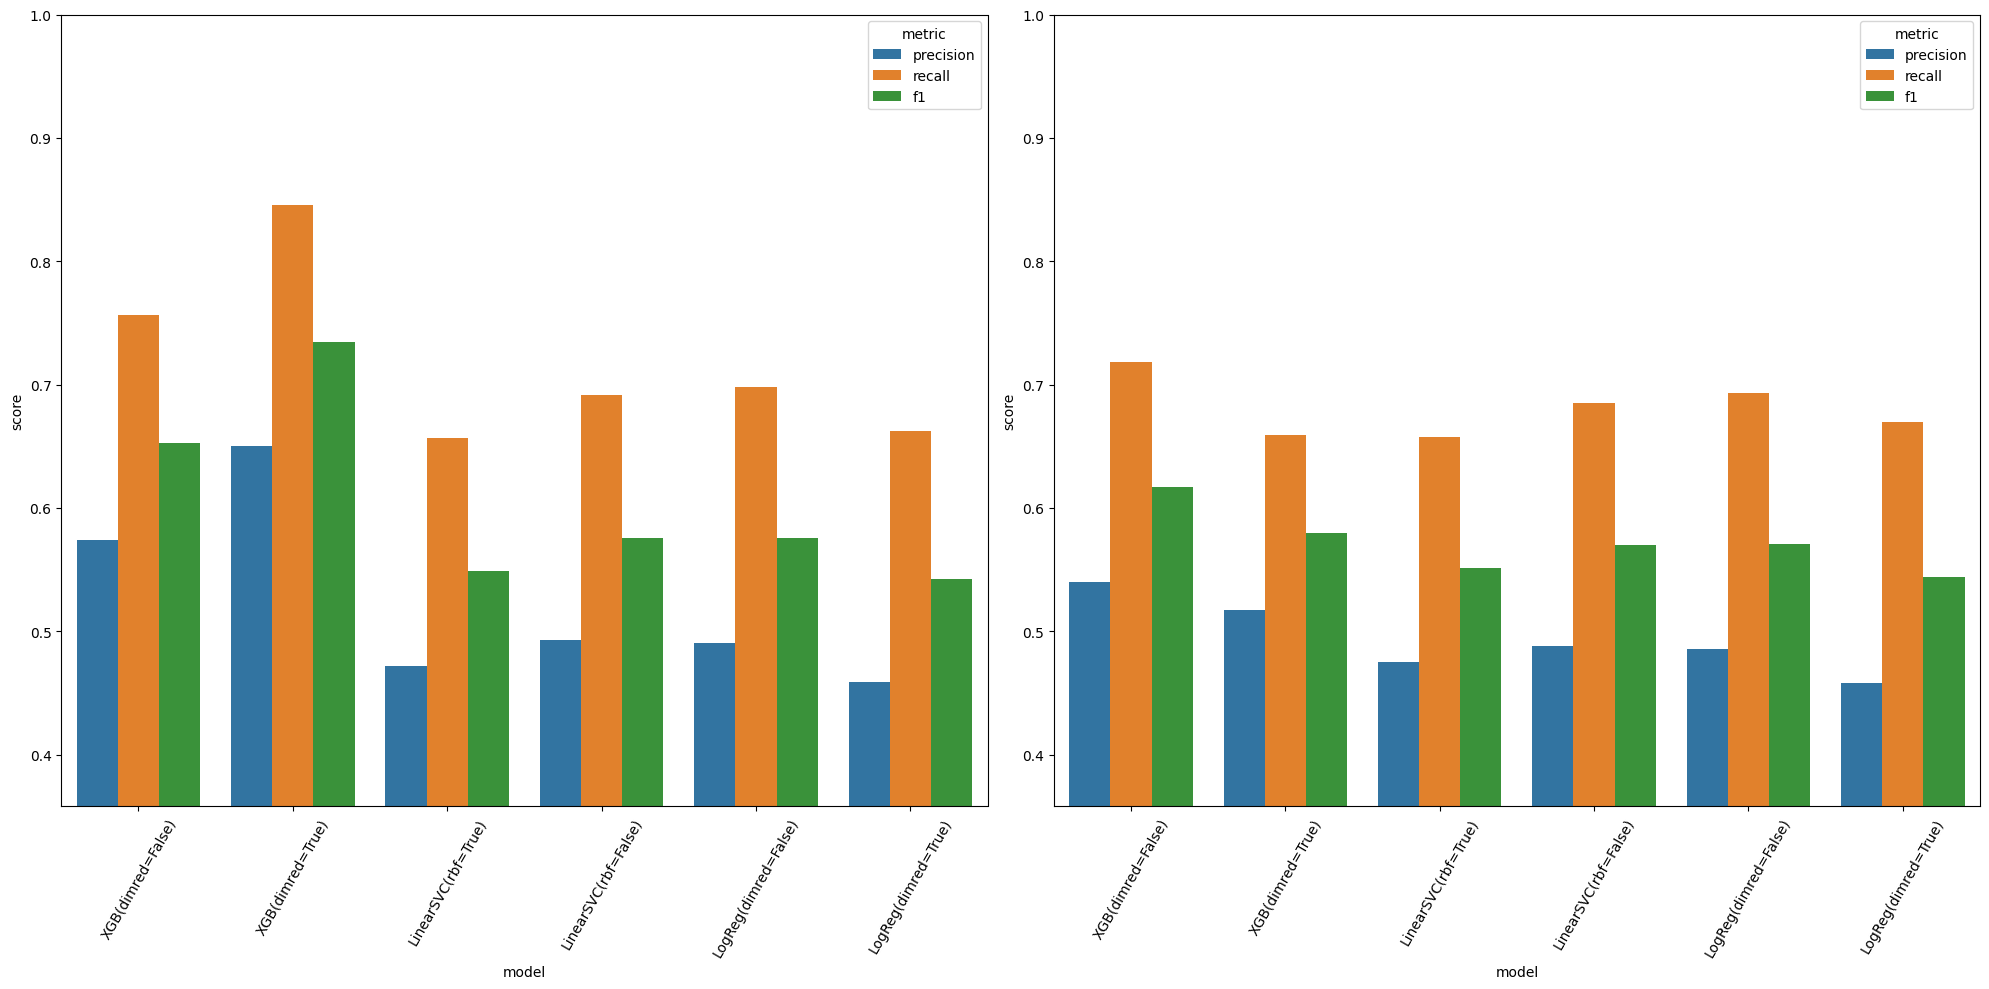

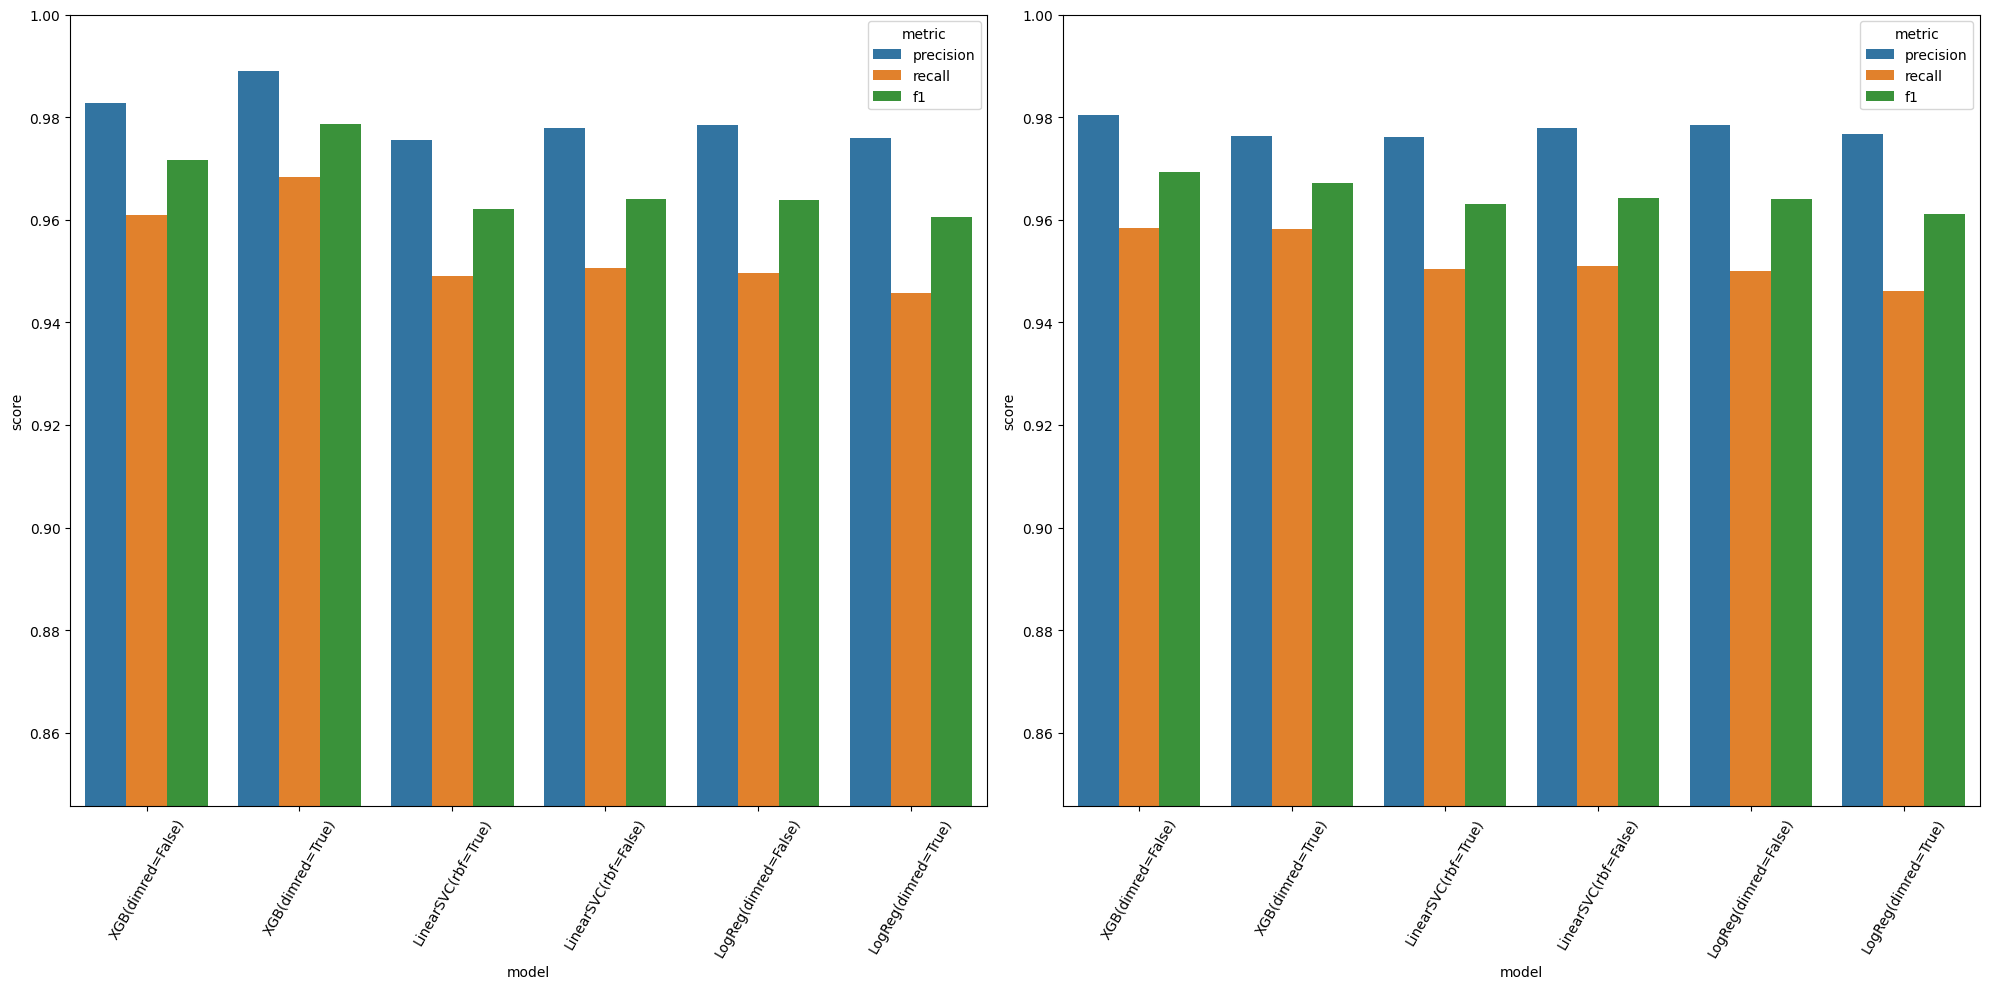

In [ ]:
# Specify your evaluation config here
eval_config = EvaluationConfig(n_repet=2,
                            model_configs=[
                                XGBConfig(n_estimators=100,
                                            max_depth=7,
                                            learning_rate=1e-1,
                                            dimension_red=None),
                                XGBConfig(weight_neg_factor=1, 
                                            weight_pos_factor=1,
                                            dimension_red=50),
                                LinearSVMConfig(rbf_gamma=5e-5, C=100),
                                LinearSVMConfig(),
                                LogisticRegressionConfig(),
                                LogisticRegressionConfig(dimension_red=50),
                            ])

ml_pipeline = MLPipe(data_config=data_config,
                     evaluation_config=eval_config)

ml_pipeline.run()